In [1]:
import sys,os

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.regularizers import l2 
from tensorflow.keras import utils

In [6]:
#test gpu config if required
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[]


In [3]:
emotion_data = pd.read_csv('data/fer2013.csv')

X_train,train_y,X_test,test_y=[],[],[],[]  
for index, row in emotion_data.iterrows():  
    val=row['pixels'].split(" ")  
    if 'Training' in row['Usage']:
      X_train.append(np.array(val,'float32'))  
      train_y.append(row['emotion'])  
    elif 'PublicTest' in row['Usage']:  
      X_test.append(np.array(val,'float32'))  
      test_y.append(row['emotion'])
        
num_features = 64  
num_labels = 7

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

batch_size = 64  
epochs = 124
width, height = 48, 48 

X_train = np.array(X_train,'float32')  
train_y = np.array(train_y,'float32')  
X_test = np.array(X_test,'float32')  
test_y = np.array(test_y,'float32')  
train_y= utils.to_categorical(train_y, num_classes=num_labels)  
test_y= utils.to_categorical(test_y, num_classes=num_labels)
X_train -= np.mean(X_train, axis=0)  
X_train /= np.std(X_train, axis=0)  
X_test -= np.mean(X_test, axis=0)  
X_test /= np.std(X_test, axis=0)  
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)  
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


## Model Definition

In [37]:
num_samples, num_classes = emotion_data.shape

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', name='image_array', input_shape=(X_train.shape[1:])))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.3))

model.add(Conv2D(filters=96, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=96, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.3))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.3))


model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))  
model.add(BatchNormalization())  
model.add(GlobalAveragePooling2D())  

model.add(Flatten()) 

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation='sigmoid'))  

In [38]:
model.compile(loss=categorical_crossentropy,  
              optimizer=Adam(),  
              metrics=['accuracy'])  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 96)       

### Callback

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0005,
    patience=11,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=10,
    verbose=1,
    mode="auto",
    min_lr=1e-7,
)

### Train

In [ ]:
history = model.fit(X_train, train_y, 
          steps_per_epoch=len(X_train) / batch_size, 
          batch_size=batch_size,  
          epochs=epochs,  
          verbose=1,  
          validation_data=(X_test, test_y),
          callbacks=[cb_early_stop,cb_reduce_lr]
          )

### Save Model

In [ ]:
model_json = model.to_json()
with open("model_data/model_4layer.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_data/model_4layer.h5")
print("model saved")

In [ ]:
np.save('model_data/history.npy',history.history)

## Load Model

In [4]:
from tensorflow.keras.initializers import glorot_uniform
#Reading the model from JSON file
with open('model_data/model_4layer.json', 'r') as json_file:
    json_savedModel= json_file.read()#load the model architecture 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('model_data/model_4layer.h5')

history=np.load('model_data/history.npy',allow_pickle='TRUE').item()

2021-10-20 02:44:02.774093: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-20 02:44:02.774122: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-20 02:44:02.774147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pipebomb-Strix-15-GL503GE): /proc/driver/nvidia/version does not exist
2021-10-20 02:44:02.774319: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-10-20 02:44:02.796515: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2299965000 Hz
2021-10-20 02:44:02.797024: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f53ac000b60 initialized for platform Host (this does not

In [5]:
model.compile(loss='sparse_categorical_crossentropy',
         optimizer=Adam(),
         metrics=['accuracy'])

## Test Model

In [6]:
score = model.predict(X_test)

pred_y = [np.argmax(item) for item in score]
true_y = [np.argmax(item) for item in test_y]

accuracy = [(x==y) for x,y in zip(pred_y,true_y)]
print("accuracy on testset: " , np.mean(accuracy))

accuracy on testset:  0.6533853441069936


## Confusion Matrix

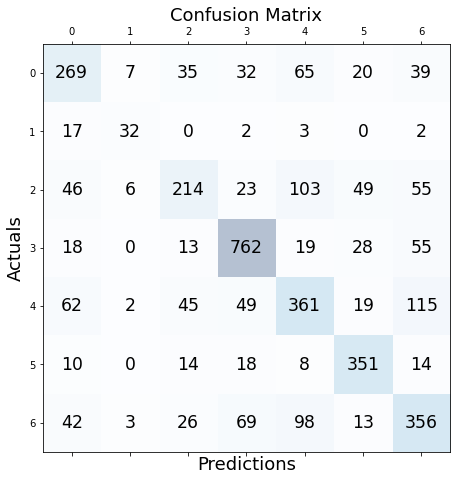

In [8]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=true_y, y_pred=pred_y)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

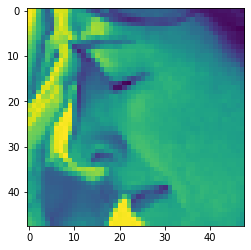

Fear


In [51]:
from matplotlib import pyplot as plt
import random

sample_number =  random.randrange(1, 1000) #@param {type:"slider", min:0, max:1000, step:1}

image = np.mat(emotion_data.pixels[sample_number]).reshape(48,48)
plt.imshow(image, interpolation='nearest')
plt.show()

detected_emotion = emotion_labels[emotion_data.emotion[sample_number]]
print(detected_emotion)


## Plotting

In [52]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='images/model.png')

plot_model(model, to_file='images/model_hz.png', rankdir='LR')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


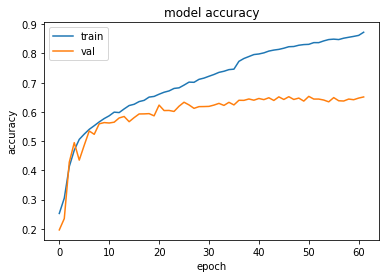

In [53]:
from matplotlib import pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

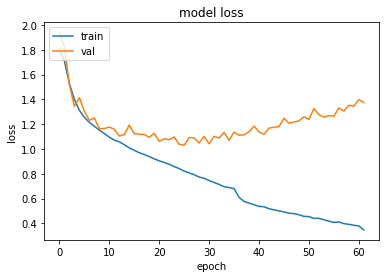

In [54]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

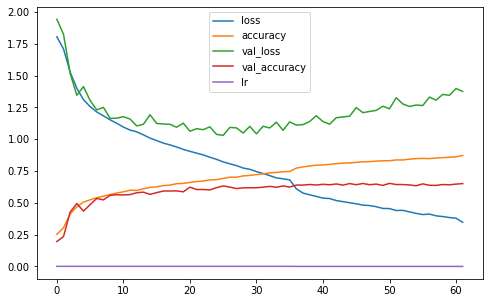

In [55]:
pd.DataFrame(history).plot(figsize=(8,5))
plt.show()